In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

In [46]:
import ops 


def calc_gradient_custom(img:np.ndarray, ksize:int):
    ddepth = cv2.CV_64F
    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=ksize)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=ksize)

    magnitude = np.sqrt(np.square(grad_x) + np.square(grad_y))
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi) # Converting from rads to degrees


    # ? Scaling the magnitude
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min()) * 255
    return magnitude, angle 


def non_maximal_custom(magnitude: np.ndarray, angle: np.ndarray):
    non_max = np.zeros_like(magnitude)
    angle = angle % 180
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            # Suppress pixels based on angle direction
            try:
                # q, r = 255, 255
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif 22.5 <= angle[i, j] < 67.5:
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif 67.5 <= angle[i, j] < 112.5:
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif 112.5 <= angle[i, j] < 157.5:
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]
                
                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    non_max[i, j] = magnitude[i, j]
                else:
                    non_max[i, j] = 0
            except IndexError as e:
                pass

    return non_max



def double_thresh_custom(non_max: np.ndarray, thresh1:int, thresh2:int):
    # if inverted 
    if thresh1 > thresh2:
        thresh1, thresh2 = thresh2, thresh1

    

    res = np.zeros_like(non_max)
    strong_i, strong_j = np.where(non_max >= thresh2)
    weak_i, weak_j = np.where((non_max < thresh2) & (non_max > thresh1))

    res[strong_i, strong_j] = thresh1
    res[weak_i, weak_j] = thresh2

    return res 


def hysteresis_custom(result, thresh1, thresh2):
    if thresh1 > thresh2:
        thresh1, thresh2 = thresh2, thresh1

    for i in range(1, result.shape[0] - 1):
        for j in range(1, result.shape[1] - 1):
            if (result[i, j] == thresh1):
                if ((result[i+1, j-1:j+2] == thresh2).any() or (result[i-1, j-1:j+2] == thresh2).any() or 
                    (result[i, [j-1, j+1]] == thresh2).any()):
                    result[i, j] = thresh2
                else:
                    result[i, j] = 0
    
    return result

39747 255.0 0.0


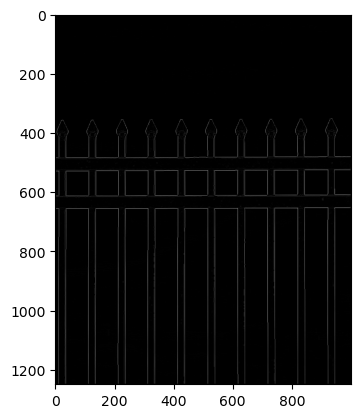

((1250, 1000, 3), (1250, 1000), (1250, 1000), (1250, 1000), (1250, 1000))

In [47]:
# Reading in the image and converting to GRAY
img = cv2.imread('data/fence.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# First we apply a gaussian filter to reduce noise in the image
blurred_img = ops.gaussianblur_custom(
    img_gray,
    kernel_size=5
)

magnitude, angle = calc_gradient_custom(blurred_img, 5)

non_max = non_maximal_custom(magnitude, angle)

print(len(np.unique(non_max)), np.max(non_max), np.min(non_max))

plt.imshow(non_max, cmap='gray')
plt.show()
img.shape, img_gray.shape, blurred_img.shape, magnitude.shape, angle.shape

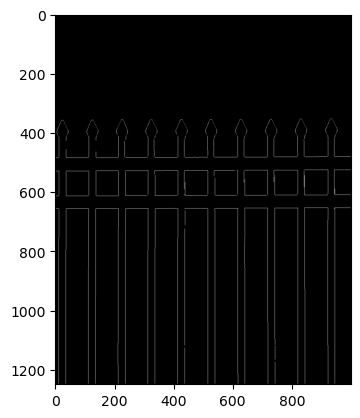

In [48]:
def double_thresh_custom(non_max: np.ndarray, thresh1:int, thresh2:int):
    # if inverted 
    if thresh1 > thresh2:
        thresh1, thresh2 = thresh2, thresh1

    

    res = np.zeros_like(non_max)
    strong_i, strong_j = np.where(non_max >= thresh2)
    weak_i, weak_j = np.where((non_max < thresh2) & (non_max > thresh1))

    res[strong_i, strong_j] = thresh1
    res[weak_i, weak_j] = thresh2

    return res 

# ? Setting thresholds the same as cv2.Canny
THRESH1 = 120
THRESH2 = 230
# TODO: problem starts with thresholding, find out why
# Might be an issue with the range of non_max
threshed_img = double_thresh_custom(non_max, THRESH1, THRESH2)



# threshed_img = np.zeros_like(non_max)
# strong_i, strong_j = np.where(non_max >= THRESH2)
# threshed_img[strong_i, strong_j] = THRESH2

final = hysteresis_custom(threshed_img, THRESH1, THRESH2)
plt.imshow(threshed_img, cmap='gray')
plt.show()


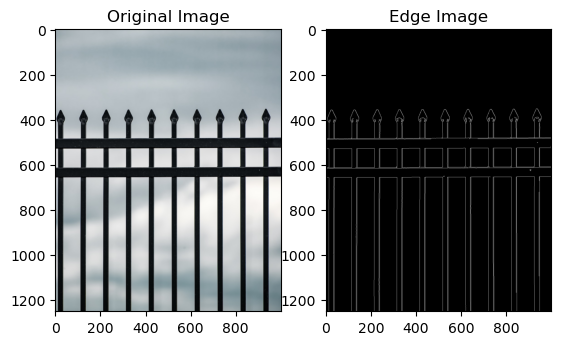

In [51]:
img = cv2.imread('data/fence.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edges = cv2.Canny(blurred_img,THRESH1,THRESH2)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.title('Edge Image')
 
plt.show()

In [52]:
from math import log10, sqrt 

def mean_squared_error(x1, x2):
    '''
    Used to calculate the mse between original image and our implementation
    '''
    return np.mean(np.square(x1 - x2))


def psnr(x1, x2): 
    '''
    Peak Signal to Noise Ratio
    '''
    mse = mean_squared_error(x1, x2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


mean_squared_error(final, edges), psnr(final, edges)

(604.3692, 20.317780372506892)